In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from math import sqrt
from keras.callbacks import History 
import gc
from numpy.random import randint, choice
import numpy.random as rng

import keras.backend as K

C:\Users\akaur\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

In [5]:
input_dim = (45,45,3)
imgSize=(45,45)

basePath = "C:/Users/akaur/Desktop/Deakin/Dataset"
trainPath = os.path.join(basePath,'Train')
testPath = os.path.join(basePath,'Test')

#### Data Exploration


#### Dataset Details: 
The OMNIGLOT dataset consists of character lists of several languages, with each character having 20 images each. 

For the purpose of training/testing, I chose the characters of the Armenian Language. I chose the language as it was a sufficiently difficult task given the similarity of the languages.

Given the task of one-shot learning, I chose to explore 2 different models:

1.	Basic CNN
2.	Siamese Networks (With CNN Base network)


The dropout regularisation technique is used for reducing the overfitting in neural networks.


#### Creating list of images

In [30]:
superList = []
folderList = sorted( os.listdir(trainPath))
numPairs = 5000



In [13]:
# Adding positive samples

for folder in folderList:
    
    imgList = os.listdir(os.path.join(trainPath,folder))
    
    pairList = []
    
    for x in range(len(imgList)-1):
        for y in range(x+1, len(imgList)):
            
            img1 = read_img(os.path.join(trainPath,folder,imgList[x]) , imgSize)
            img2 = read_img(os.path.join(trainPath,folder,imgList[y]) , imgSize)
            
            pairList.append(((img1,img2),1))
            
    np.random.shuffle(pairList)
    finalList = pairList[:150]
    superList = superList + finalList
    

for i in range(2000):
    
    folder = choice(folderList)
    
    imgList = choice( os.listdir(os.path.join(trainPath,folder)), 2, replace = False ) 
    
    img1 = read_img(os.path.join(trainPath,folder,imgList[0]), imgSize)
    img2 = read_img(os.path.join(trainPath,folder,imgList[1]), imgSize)
    
    superList.append(((img1,img2),1))
    

print(len(superList))

5150


In [ ]:
for i in range(len(folderList)-1):
    for j in range(i,len(folderList)):
        
        pairList = []
        
        folder1 = folderList[i]
        folder2 = folderList[j]
        
        #print("{} {}".format(folder1,folder2))
        
        imgList1 = os.listdir(os.path.join(trainPath,folder1))
        imgList2 = os.listdir(os.path.join(trainPath,folder2))
        
        for x in range(len(imgList1)):
            for y in range(len(imgList2)):
                
                img1 = read_img(os.path.join(trainPath,folder1,imgList1[x]) , imgSize)
                img2 = read_img(os.path.join(trainPath,folder2,imgList2[y]) , imgSize)
                
                pairList.append(((img1,img2),0))
        
        np.random.shuffle(pairList)
        finalList = pairList[:35]
        superList = superList+finalList

        
        
        

In [14]:
np.random.shuffle(superList)

#### Display image

In [53]:
def display_image(folder1,img1,folder2,img2,train1=True,train2=True):
    
    
    if train1 == True:
        image1 = sorted(os.listdir(os.path.join(trainPath,folder1)))[img1]
        image1 = read_img(os.path.join(trainPath,folder1,image1), imgSize)
    else:
        image1 = sorted(os.listdir(os.path.join(testPath,folder1)))[img1]
        image1 = read_img(os.path.join(testPath,folder1,image1), imgSize)
        
    if train2 == True:
        image2 = sorted(os.listdir(os.path.join(trainPath,folder2)))[img2]
        image2 = read_img(os.path.join(trainPath,folder2,image2), imgSize)
    else:
        image2 = sorted(os.listdir(os.path.join(testPath,folder2)))[img2]
        
        image2 = read_img(os.path.join(testPath,folder2,image2), imgSize)
        
    plt.subplot(211)
    plt.imshow(image1)
    
    plt.subplot(212)
    plt.imshow(image2)
    

0028_18.png
[[0.60623467]]


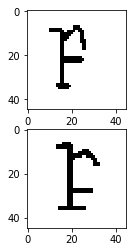

In [82]:
display_image('character02',5,'character02',2,train1= True, train2= False)

#### Model Selection

The major challenge with One-Shot Learning is the limited amount of data available to classify between numerous classes. Given the nature of the dataset, CNN was chosen since its the default neural network choice for working with images. However, given the need of basic CNNs for large amounts of data to work properly, we also look at a variant known as Siamese Networks


#### Defining functions for the model

In [16]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)


def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#### Defining the model

In [21]:
baseModel = Sequential()
baseModel.add(BatchNormalization(input_shape = input_dim))
baseModel.add(Conv2D(64, (7,7),activation='relu', data_format='channels_last',kernel_initializer=W_init))
baseModel.add(MaxPooling2D())

baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(128, (5,5),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(256, (3,3),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Flatten())
baseModel.add(Dense(1028, activation='relu'))
# baseModel.add(Dense(32, activation='relu'))


inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)


#Extracting data
inputAimgs = np.array([x[0][0] for x in superList])
inputBimgs = np.array([x[0][1] for x in superList])
target = np.array([x[1] for x in superList])

#### Loss functions used : 
CNN uses Crossentropy as the loss function
and Siamese Network uses Contrastive Loss as the loss function. I used Adadelta optimiser because of its adaptive learning rate.


### CNN Model


In [18]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([outputA, outputB])
prediction = Dense(1,activation='sigmoid')(L1_distance)
CNN = Model(inputs=[inputA,inputB],outputs=prediction)

CNN.compile(loss="binary_crossentropy",optimizer='adadelta',metrics=['accuracy'])

In [19]:
CNN.fit([inputAimgs,inputBimgs], target, batch_size = 20,epochs = 10 )

Epoch 1/10
5150/5150 [==============================] - 608s 118ms/step - loss: 0.0032 - acc: 0.9998
Epoch 2/10
5150/5150 [==============================] - 568s 110ms/step - loss: 6.0920e-06 - acc: 1.0000
Epoch 3/10
5150/5150 [==============================] - 615s 119ms/step - loss: 3.6415e-06 - acc: 1.0000
Epoch 4/10
5150/5150 [==============================] - 634s 123ms/step - loss: 2.0139e-06 - acc: 1.0000
Epoch 5/10
5150/5150 [==============================] - 675s 131ms/step - loss: 1.0196e-06 - acc: 1.0000
Epoch 6/10
5150/5150 [==============================] - 971s 189ms/step - loss: 1.3161e-06 - acc: 1.0000
Epoch 7/10
5150/5150 [==============================] - 36337s 7s/step - loss: 8.7138e-07 - acc: 1.0000
Epoch 8/10
5150/5150 [==============================] - 696s 135ms/step - loss: 7.6264e-07 - acc: 1.0000
Epoch 9/10
5150/5150 [==============================] - 845s 164ms/step - loss: 4.5746e-07 - acc: 1.0000
Epoch 10/10
5150/5150 [==============================] - 750

### Siamese Net Model

In [23]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([outputA,outputB])

Siamese = Model(input=[inputA, inputB], output=distance)

Siamese.compile(loss=contrastive_loss,optimizer='adadelta')


C:\Users\akaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [165]:
Siamese.fit([inputAimgs,inputBimgs], target, batch_size = 30,epochs = 10 )

Epoch 1/10
21390/21390 [==============================] - 112s 5ms/step - loss: 0.1940
Epoch 2/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1344
Epoch 3/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1115
Epoch 4/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1018
Epoch 5/10
21390/21390 [==============================] - 110s 5ms/step - loss: 0.0942
Epoch 6/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0893
Epoch 7/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0855
Epoch 8/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0823
Epoch 9/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0795
Epoch 10/10
21390/21390 [==============================] - 107s 5ms/step - loss: 0.0764


#### Performance Metrics/Loss Functions
 Since the task involved is a classification one, I have used accuracy as the performance metric for the task. An important difference however, is the number of classes being used in the testing process. Since One-Shot learning focuses on the ability to classify a large number of classes based on lesser amounts of data, the accuracy is tested for different number of classes. This is known as N-way accuracy.For eg., while testing, if only 20 classes are considered for classification, then it is known as 20-way accuracy.



## Testing

In [25]:

def getSupportImgs(path):
    
    supportImg=[]
    
    os.chdir(path)
    folderList = os.listdir("./")
    
    for folder in folderList:
        os.chdir(os.path.join(path,folder))
        imgList = os.listdir("./")
        
        img = read_img(os.path.join(path,folder,choice(imgList)), imgSize)
        supportImg.append([img,folder])
        
    return(supportImg)
        

def predictBestFolder(img,label,trainPath,model,numImages = 5,printList = False,testClasses = 30):
    
    predList = []
    
    folderList = sorted(os.listdir(trainPath))[:testClasses]
    
    for folder in folderList:
        
        imgList = choice(os.listdir(os.path.join(trainPath,folder)), numImages, replace = False )
        folderPreds = []
        
        for i in range(numImages):
            folderImg = read_img(os.path.join(trainPath,folder,imgList[i]), imgSize )
            pred = model.predict([img.reshape(1,imgSize[0],imgSize[1],3), folderImg.reshape(1,imgSize[0],imgSize[1],3)])
            folderPreds.append(pred)
        
        predList.append([folder, np.mean(folderPreds)])
    
    predList = sorted(predList, key = lambda x:x[1])
    
    if printList == True:
        print(predList)
        
    return(predList[0])




#### Accuracy of Siamese model on test data

In [169]:
# 20-way testing

os.chdir(testPath)
folderList = sorted(os.listdir("./"))[:20]

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(testPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        
        img = read_img(os.path.join(testPath,folder,img), imgSize)
        bestLabel = predictBestFolder(img,folder,trainPath,Siamese,15,testClasses=20)[0]
        
        if bestLabel == folder:
            correctPred+=1
        acc = round(correctPred/float(testImageCount),3)
        print("Img : {} True Label : {}  Predicted Label : {} Accuracy : {}".format(imgName,folder,bestLabel,acc))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))



Img : 0027_20.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_16.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_19.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_18.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_17.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0028_20.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_17.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_18.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_16.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_19.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0029_19.png True Label : character03  Predicted Label : character03 Accuracy : 1.0
Img : 0029_16.png Tru

Img : 0045_17.png True Label : character19  Predicted Label : character19 Accuracy : 0.793
Img : 0045_20.png True Label : character19  Predicted Label : character19 Accuracy : 0.796
Img : 0045_16.png True Label : character19  Predicted Label : character19 Accuracy : 0.798
Img : 0045_19.png True Label : character19  Predicted Label : character19 Accuracy : 0.8
Img : 0046_18.png True Label : character20  Predicted Label : character20 Accuracy : 0.802
Img : 0046_17.png True Label : character20  Predicted Label : character20 Accuracy : 0.804
Img : 0046_20.png True Label : character20  Predicted Label : character20 Accuracy : 0.806
Img : 0046_16.png True Label : character20  Predicted Label : character20 Accuracy : 0.808
Img : 0046_19.png True Label : character20  Predicted Label : character20 Accuracy : 0.81
Accuracy : 0.81


In [171]:
save_model(model,'./bestModel_0.81.hdf5')

#### Accuracy of CNN on test data

In [27]:
# 20-way testing

os.chdir(testPath)
folderList = sorted(os.listdir("./"))[:20]

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(testPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        
        img = read_img(os.path.join(testPath,folder,img), imgSize)
        bestLabel = predictBestFolder(img,folder,trainPath,CNN,15,testClasses=20)[0]
        
        if bestLabel == folder:
            correctPred+=1
        acc = round(correctPred/float(testImageCount),3)
        print("Img : {} True Label : {}  Predicted Label : {} Accuracy : {}".format(imgName,folder,bestLabel,acc))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Img : 0027_16.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_17.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_18.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_19.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_20.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0028_16.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_17.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_18.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_19.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_20.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0029_16.png True Label : character03  Predicted Label : character07 Accuracy : 0.909
Img : 0029_17.png T

Img : 0045_17.png True Label : character19  Predicted Label : character17 Accuracy : 0.304
Img : 0045_18.png True Label : character19  Predicted Label : character01 Accuracy : 0.301
Img : 0045_19.png True Label : character19  Predicted Label : character08 Accuracy : 0.298
Img : 0045_20.png True Label : character19  Predicted Label : character18 Accuracy : 0.295
Img : 0046_16.png True Label : character20  Predicted Label : character01 Accuracy : 0.292
Img : 0046_17.png True Label : character20  Predicted Label : character01 Accuracy : 0.289
Img : 0046_18.png True Label : character20  Predicted Label : character20 Accuracy : 0.296
Img : 0046_19.png True Label : character20  Predicted Label : character20 Accuracy : 0.303
Img : 0046_20.png True Label : character20  Predicted Label : character20 Accuracy : 0.31
Accuracy : 0.31


#### Results 20-way accuracy

The Siamese Network model outperforms CNN model for one shot learning. 

The CNN model requires large amount of data to learn and adjust the parameters of the model. The less amount of data i.e. just few examples per image resulted in poor performace of CNN model. 

The similarity function in Siamese network that measures the degree of difference between images helps to learn the model from less amount of data while giving good performance results.
 

CNN	     31%
Siamese Networks	81%



